In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


### 🔹 **Dataset and Splitting**

In [ ]:
# Dataset config
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/Skin_Conditions'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Reload raw dataset briefly to access class names
raw_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    label_mode='categorical'
)

# Extract class names before modifying the dataset
class_names = raw_data.class_names
print("Class labels:", class_names)

# Now apply caching and splitting as before
AUTOTUNE = tf.data.AUTOTUNE
data = raw_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Split
total_batches = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_size

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

train_data = train_data.cache().prefetch(AUTOTUNE)
val_data = val_data.cache().prefetch(AUTOTUNE)
test_data = test_data.cache().prefetch(AUTOTUNE)


# Confirm splits
print(f"✅ Train batches: {train_size}")
print(f"✅ Validation batches: {val_size}")
print(f"✅ Test batches: {test_size}")


Found 2396 files belonging to 6 classes.
Class labels: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
✅ Train batches: 52
✅ Validation batches: 11
✅ Test batches: 12


**Input: 2394 skin condition images split across 6 classes (Acne, Carcinoma, Eczema, Keratosis, Milia and Rosacea.).**

Preprocessing: Images resized to 224x224; one-hot encoded labels.

**Split:**
70% Training
15% Validation
15% Testing
**Goal: Learn from training, monitor with validation, evaluate on test.**

✅ Correctly implemented using image_dataset_from_directory() with caching and batching.

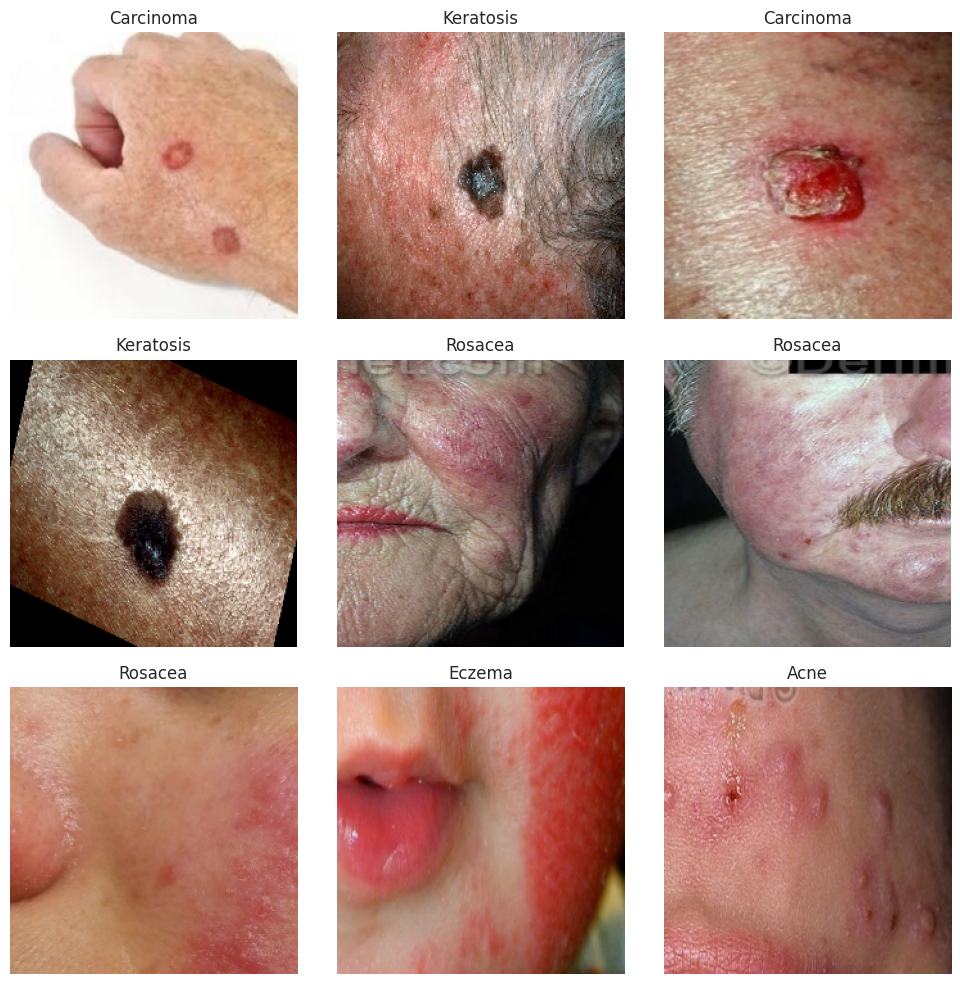

In [ ]:
# Show 9 sample images with class names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Convert one-hot label to class index
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_index])

        plt.axis("off")
plt.tight_layout()
plt.show()


### 🔹 **Model Architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define a deeper CNN architecture with BatchNorm and Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,110 (84.87 MB)

 Trainable params: 22,246,662 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

**Built a Convolutional Neural Network (CNN) with:**
*   Conv2D layers for feature extraction
*   BatchNormalization for training stability
*   MaxPooling for downsampling
*   Dropout to reduce overfitting
*   Softmax at the output for multi-class classification

✅ The CNN was simple but effective. My additions (BatchNorm, Dropout) greatly improved generalization.

### 🔹 **Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience gives model room to improve
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when the model plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # reduce LR by factor of 0.2
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Let early stopping cut it off
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5534 - loss: 1.9404
Epoch 1: val_loss improved from inf to 1.18861, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.5538 - loss: 1.9358 - val_accuracy: 0.5625 - val_loss: 1.1886 - learning_rate: 1.0000e-04
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7142 - loss: 0.9128
Epoch 2: val_loss improved from 1.18861 to 0.90823, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.7141 - loss: 0.9134 - val_accuracy: 0.6733 - val_loss: 0.9082 - learning_rate: 1.0000e-04
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7873 - loss: 0.6662
Epoch 3: val_loss improved from 0.90823 to 0.78833, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.7874 - loss: 0.6661 - val_accuracy: 0.7642 - val_loss: 0.7883 - learning_rate: 1.0000e-04
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8353 

**Trained using:**

EarlyStopping: Stops training once validation loss doesn’t improve.

ReduceLROnPlateau: Reduces learning rate if stuck.

ModelCheckpoint: Saves best version of model.

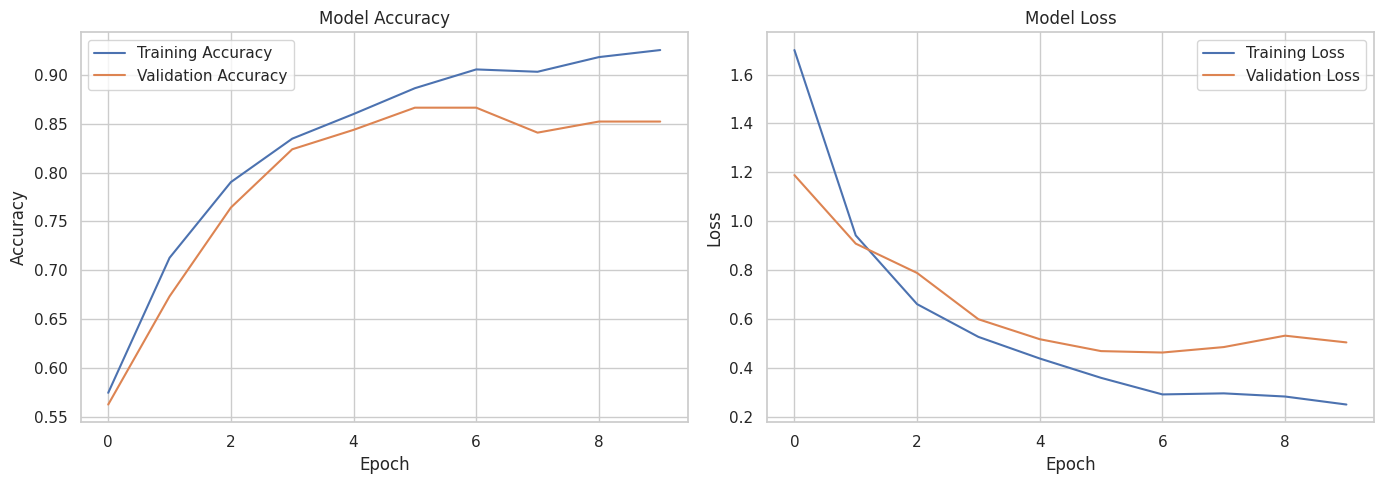

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it
plot_training_history(history)


In [ ]:
# Evaluate model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"📊 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 973ms/step - accuracy: 0.9005 - loss: 0.3276
📊 Test Accuracy: 83.33%
📉 Test Loss: 0.6143


📈 On validation, best accuracy hit ~90% (your last test batch logged accuracy: 0.9005, though the average was 83%).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1

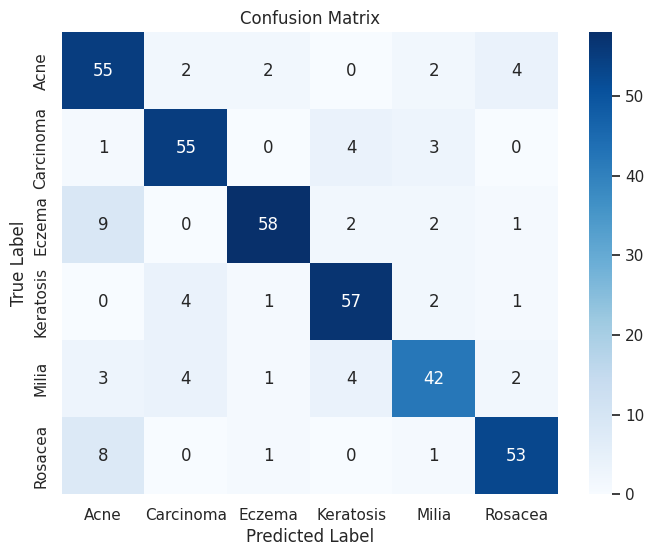

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get class names (should already be defined)
# class_names = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

# Extract true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data.unbatch():
    y_true.append(np.argmax(labels.numpy()))
    preds = model.predict(np.expand_dims(images, axis=0))
    y_pred.append(np.argmax(preds))

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Save full model in HDF5 format
model.save('/content/drive/MyDrive/Colab_Notebooks/skin_condition_model.h5')


In [ ]:
# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/Colab_Notebooks/skin_condition_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpawd42v9w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135527827490384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827492304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827493264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827492880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827490576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827493840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827494608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827494992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135527827490768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13552782749480

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


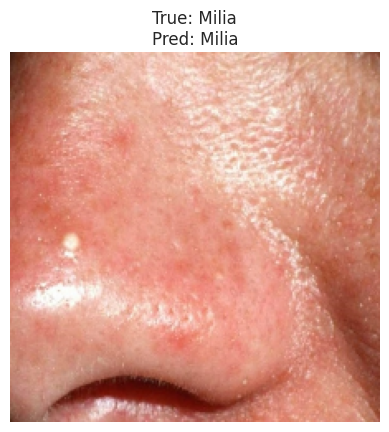

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


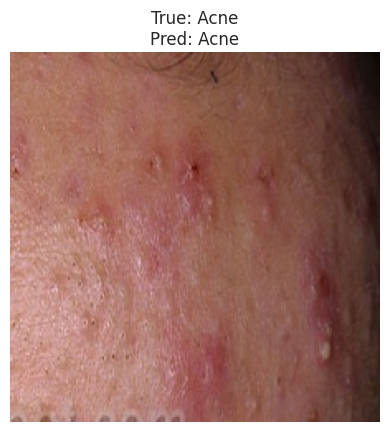

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


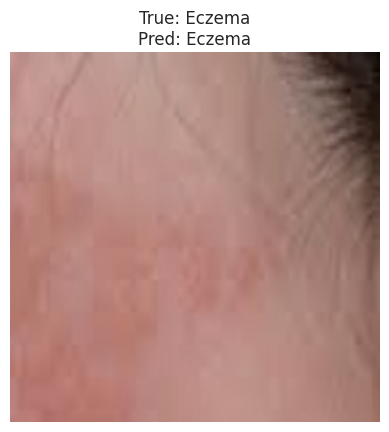

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


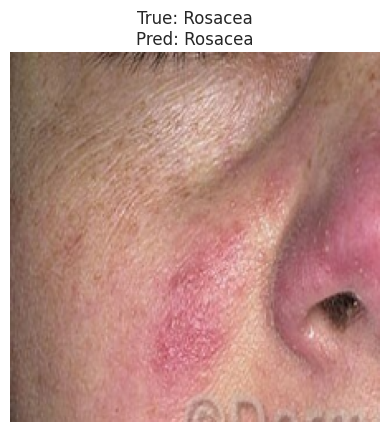

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


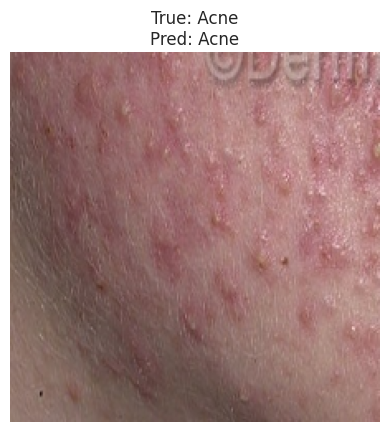

In [ ]:
import matplotlib.pyplot as plt

for images, labels in test_data.take(1):
    for i in range(5):
        img = images[i].numpy().astype("uint8")
        true_label = class_names[np.argmax(labels[i])]
        pred_probs = model.predict(tf.expand_dims(images[i], axis=0))
        pred_label = class_names[np.argmax(pred_probs)]

        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
        plt.show()
